In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("./ClusterTrellis/src")

In [3]:
import os
import pickle
import string
import time
import logging
import numpy as np
import importlib

In [4]:
from ClusterTrellis import run_experiments as rpe
from ClusterTrellis import HierarchicalTrellis
from ClusterTrellis.trellis_node import TrellisNode

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)

import matplotlib as mpl
from matplotlib import rcParams
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib import ticker
from matplotlib import colors
from matplotlib.patches import Ellipse
from matplotlib import gridspec

import matplotlib
#matplotlib.rc('font',**{'family':'serif','serif':['Times']})
#matplotlib.rc('text', usetex=True) 
matplotlib.rcParams.update({'font.size': 10})

In [6]:
from ClusterTrellis.utils import get_logger
logger = get_logger(level=logging.WARNING)

# General remarks

The Hierarchical Cluster Trellis data structure and algorithms to calculate the partition function and MAP hierarchies are introduced in https://arxiv.org/abs/2002.11661

To run the Cluster Trellis on a new model, define the get_energy_of_split and compute_map_features methods in the ModelNode class below. In particular,  get_energy_of_split represents the potential function $\psi$ introduced in the paper, describing the compatibility of a pair of sibling nodes in a hierarchy $H$.

The energy function $\psi$ for a pairwise splitting should be written in terms of the map_features and model_params. Thus, compute_map_features is an auxiliary function to calculate features of internal vertices in the trellis. The current implementation assumes that the model parameters are the same for every vertex in the trellis.

- map_features : list, where each entry is a list with the model features/values for each vertex of a dataset. In particular, we initialize the algorithm with the leaves_features list as [feature1, feature2, ... , featureN]. E.g. for Ginkgo this is [momentum, invariant mass] for each leaf.

- model_params : dictionary with the model parameters.



# Interfacing on Ginkgo

In [7]:
"""Replace with model auxiliary scripts to calculate the energy function"""
#from ClusterTrellis import Ginkgo_likelihood as likelihood
from ginkgo import likelihood_invM as likelihood

In [8]:
class ModelNode(TrellisNode):
    """Class to define the node pairwise splitting energy and calculate node features for a given model """

    def __init__(self,
                 model_params,
                 elements = None,
                 children = None,
                 map_features = None):
        TrellisNode.__init__(self, model_params, elements, children, map_features)


    def get_energy_of_split(self, a_node, b_node):
        """Model energy function.
        Args: sibling nodes
        returns: model pairwise splitting energy
        """

        logger.debug(f"computing energy of split: {a_node, b_node}")

        split_llh = likelihood.split_logLH_with_stop_nonstop_prob(a_node.map_features,
                                           b_node.map_features,
                                           self.model_params["delta_min"],
                                           self.model_params["lam"])
        logger.debug(f"split_llh = {split_llh}")

        return split_llh


    def compute_map_features(self, a_node, b_node):
        """Auxiliary method to get the parent vertex features. This is model dependent. In Ginkgo these are the momentum and parent         invariant mass.
        Args: sibling nodes
        returns: list where each entry is a parent feature, e.g. [feature1,feature2,...]
        """
        momentum = a_node.map_features + b_node.map_features
        logger.debug(f"computing momentum for {a_node, b_node, momentum}")

        
#         logger.debug(f"computing  parent invariant mass {a_node, a_node.map_features, b_node, b_node.map_features}")
#         pP = a_node.map_features + b_node.map_features

#         """Parent invariant mass squared"""
#         tp1 = pP[0] ** 2 - np.linalg.norm(pP[1::]) ** 2
#         logger.debug(f"tp =  {tp1}")

        return momentum

/ext3/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load Datsets

In [9]:
#label = "Trellis"; plotDir = "../experiments/plots/"

In [10]:
def load_jets(root_dir, filename):
    """Load truth binary trees"""
    #root_dir = "../data/"
    filename = os.path.join(root_dir, filename)
    with open(filename + ".pkl", "rb") as fd:
        Truth= pickle.load(fd, encoding='latin-1')
    return Truth

In [11]:
gt_trees = load_jets("data", "ginkgo_5000_jets_no_cuts_lambda_21_pt_min_36_jetp_400")  # My test file

In [12]:
len(gt_trees)

5000

# Run Exact trellis on truth trees step by step

Replace leaves_features and model_params with current model values

In [14]:
"""Find MAP hierarchy and partition function """
times=[]
MAP = []
likelihoods = []
for i in range(2):
    
    """Dataset"""
    data_params = gt_trees[i]
    
    """Number of elements"""
    N=len(data_params['leaves'])

    """Replace with leaves features for current model"""
    leaves_features =[ data_params['leaves'][i] for i in range(N)]
    
    """Replace with current model parameters
    """
    model_params ={}
    model_params["delta_min"] = float(data_params['pt_cut'])
    model_params["lam"]= float(data_params['Lambda'])
    
    startTime = time.time()
    
    """ Create trellis"""
    a_trellis = HierarchicalTrellis.HierarchicalTrellis()
    a_trellis.create_from_leaves(leaves_features, 
                                                  model_params, 
                                                  NodeClass = ModelNode)
    
    """Compute MAP (MLE), partition function Z"""
    map_energy, Z , Ntrees= np.float64(a_trellis.compute_map_tree())
    endTime = time.time() - startTime
    
    times.append(endTime)
    likelihoods.append(Z)
    MAP.append(map_energy)

In [15]:
print("Maximum likelihood hierarchy = ",  MAP)
print("Likelihood of data =", likelihoods)
print("times = ",times)

Maximum likelihood hierarchy =  [-53.73657706548606, -35.89001888229393]
Likelihood of data = [-47.35023933863254, -32.30073910531696]
times =  [0.5110373497009277, 0.06080222129821777]


# Run Trellis and fill results with MAP and Partition Function Z 

Replace leaves_features and model_params with current model values

In [16]:
def runTrellisOnly(gt_trees,
                   model_params,
                   NleavesMin =3, 
                   NleavesMax= 4, 
                   MaxNjets = 1):
    
    """Create and fill the trellis for a given set of leaves
    Args: 
    gt_trees : truth level  trees.
    NleavesMin: minimum number of leaves to select  trees
    NleavesMax: maximum number of leaves to select  trees
    MaxNjets: maximum number of trees to run the trellis code.
    
    Returns:
    results: dictionary with the following {key:values}
                Z: partition functions,
                trellis_MLE: MAP hierarchy, 
                RunTime: time for each tree
                totJets": total number of trees
                gt_llh: truth level trees llh
 
    """
    
    """ Keep only trees with leaves between NleavesMin and NleavesMax"""
    smallJetIndex =[i for i,gt_tree in enumerate(gt_trees)  if NleavesMin<=len(gt_tree["leaves"])<NleavesMax]
            
    
    results = {"Z":[], "trellis_MLE":[], "RunTime":[], "Ntrees":[]}
    
    if len(smallJetIndex)>0:
        
        GT_trees = np.asarray(gt_trees)[smallJetIndex]
        
        """ Total number of trees to run the trellis"""
        totTrees = np.min([MaxNjets,len(smallJetIndex)])

        results["totTrees"] = totTrees
        results["Nleaves"] = [len(GT_trees[m]["leaves"]) for m in range(totTrees)]
        results["gt_llh"]= [np.sum(GT_trees[m]["logLH"]) for m in range(totTrees)]

        for m in range(totTrees):

            #if m%50==0:
            #    print("Creating trellis for jet #",m)
                
            startTime = time.time()
            
            data_params = GT_trees[m]
            N=len(data_params['leaves'])
            
            """Replace with current model parameters"""
            leaves_features =[ data_params['leaves'][i] for i in range(N)]
            #model_params ={}
            #model_params["delta_min"] = float(data_params['pt_cut'])
            #model_params["lam"]= float(data_params['Lambda'])

            """ Create and fill the trellis"""
            trellis, Z, map_energy, Ntrees,  totTime = rpe.compare_map_gt_and_bs_trees(GT_trees[m],
                                                                                       ModelNode,
                                                                                       leaves_features,
                                                                                       model_params)

            results["Z"].append(Z)
            results["trellis_MLE"].append(map_energy)
            results["Ntrees"].append(Ntrees)

            endTime = time.time() - startTime
            results["RunTime"].append(endTime)

    else:
        print("There are no jets in the dataset with the required number of leaves ")

    return results, trellis

## Run a few trellis algorithms on a given set of parameters

In [17]:
NleavesMin =4
NleavesMax=8
MaxNjets = 5

model_params = {"delta_min": 10, "lam": 1.5}

start = time.time()
results10, trellis10 =  runTrellisOnly(gt_trees, 
                                       model_params,
                                       NleavesMin =NleavesMin, 
                                       NleavesMax= NleavesMax, 
                                       MaxNjets = MaxNjets)

print("Total time = ", time.time() - start)

Total time =  0.402327299118042


In [18]:
results10["Z"]

[-43.44432115887727,
 -42.543417937541506,
 -32.91910720917589,
 -33.85903588753131,
 -48.60749017753346]

In [19]:
results10["trellis_MLE"]

[-47.462072945903,
 -47.05788582016389,
 -36.96852106393392,
 -35.981073304856444,
 -54.78168030239093]

In [20]:
results10["Nleaves"]

[6, 6, 6, 5, 7]

In [21]:
results10

{'Z': [-43.44432115887727,
  -42.543417937541506,
  -32.91910720917589,
  -33.85903588753131,
  -48.60749017753346],
 'trellis_MLE': [-47.462072945903,
  -47.05788582016389,
  -36.96852106393392,
  -35.981073304856444,
  -54.78168030239093],
 'RunTime': [0.060769081115722656,
  0.06241583824157715,
  0.06095290184020996,
  0.021274089813232422,
  0.183302640914917],
 'Ntrees': [840.0, 840.0, 840.0, 90.0, 10395.0],
 'totTrees': 5,
 'Nleaves': [6, 6, 6, 5, 7],
 'gt_llh': [-36.61776852607727,
  -37.959691286087036,
  -38.94296383857727,
  -27.801023960113525,
  -46.4423565864563]}

## Test a grid search

In [21]:
gt_trees[0]["pt_cut"], gt_trees[0]["Lambda"]

(36.0, tensor(2.1000))

In [22]:
gt_trees[25]["leaves"]

array([[ 78.07177753,  47.06198737,  44.39343007,  43.49505016],
       [208.779298  , 120.30239049, 120.68988559, 120.61533308],
       [ 76.39401051,  43.42661549,  43.64774367,  45.21960932],
       [ 16.14635555,   9.49412441,   9.19007343,   8.27433209],
       [ 12.47636631,   6.68554264,   6.89288947,   7.7335951 ],
       [  9.25561739,   3.969449  ,   6.1260871 ,   5.60218957]])

In [ ]:
NleavesMin =1
NleavesMax=30
MaxNjets = 100

n_cuts = 30
n_lambda = 30

cut_vals = np.linspace(4, 120, n_cuts)
lambda_vals = np.round(np.exp(np.linspace(np.log(1e-3), np.log(5), n_lambda)), decimals=6)
#lambda_vals = np.linspace(0.1, 3.5, n_lambda)
grid_cut, grid_lambda = np.meshgrid(cut_vals, lambda_vals)

max_Z = -np.inf
mle_params = None
likelihood_surface = np.zeros((30,30))

start = time.time()
for i in range(n_cuts):
    for j in range(n_lambda):
        model_params = {"delta_min": grid_cut[j,i], "lam": grid_lambda[j,i]}

        results, _ =  runTrellisOnly(gt_trees, 
                                     model_params,
                                     NleavesMin =NleavesMin, 
                                     NleavesMax= NleavesMax, 
                                     MaxNjets = MaxNjets)
        total_Z = np.sum(results["Z"])
        likelihood_surface[j,i] = total_Z
        if total_Z > max_Z:
            #print(results["Z"][0], max_Z)
            max_Z = total_Z
            mle_params = model_params
        

print("Total time = ", time.time() - start)

In [ ]:
print(max_Z)
print(mle_params)

In [ ]:
likelihood_surface[np.isnan(likelihood_surface)] = -np.inf
mle_coords = np.unravel_index(np.argmax(likelihood_surface, axis=None), likelihood_surface.shape)
mle_coords

In [ ]:
truth_bin = [None, None]
for ix, x in enumerate(cut_vals >= 36):
    if x.item() is True:
        truth_bin[0] = ix-1
        print(ix-1)
        break
        
for ix, x in enumerate(lambda_vals >= 2.1):
    if x.item() is True:
        truth_bin[1] = ix-1
        print(ix-1)
        break

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(8,8)

cm = ax.imshow(likelihood_surface, cmap="PuBuGn", interpolation="none", extent=[0,30,0,30], origin="lower")
ax.plot(mle_coords[1]+0.5, mle_coords[0]+0.5, '*', color='yellow', markersize=9, label="MLE")
ax.plot(truth_bin[0]+0.5, truth_bin[1]+0.5, "*", color="red", markersize=9, label="Truth")
cb = fig.colorbar(cm, ax=ax, shrink=0.82)
cb.set_label(label="Log Likelihood", size=18)
ax.legend(labelcolor="white", facecolor="black", fontsize="large")

ax.set_title("Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Stopping Value (pt_cut/delta_min)", size=13)
ax.set_ylabel("Splitting Parameter ($\lambda$)", size=13)
ax.set_xticks(np.arange(0, 30, 3))
ax.set_yticks(np.arange(0, 30, 3))
ax.set_xticklabels(np.round(cut_vals[::3], decimals=0))
ax.set_yticklabels(np.round(lambda_vals[::3], decimals=3));

#fig.savefig("likelihood_landscape3.png")

In [ ]:
#np.save("../data/likelihood_fit_ginkgo_100_jets_lambda_21_pt_min_36_jetp_400.npy", likelihood_surface)

### Load likelihood data

In [16]:
likelihood_surface = np.load("data/likelihood_fit_trellis_ginkgo_1000_jets_lambda_21_pt_min_36_jetp_400.npy")

In [20]:
n_cuts = 40
n_lambda = 40
N_jets = 1000

cut_vals = np.linspace(4, 90, n_cuts)
lambda_vals = np.linspace(1e-1, 5, n_lambda)

In [21]:
likelihood_surface[np.isnan(likelihood_surface)] = -np.inf
mle_coords = np.unravel_index(np.argmax(likelihood_surface, axis=None), likelihood_surface.shape)
mle_coords

(7, 13)

In [22]:
lambda_vals[mle_coords[0]], cut_vals[mle_coords[1]]

(0.9794871794871794, 32.66666666666667)

## Load Grid Search Batches

In [35]:
def get_likelihood_surface(cut_min, cut_max, n_cuts,
                           lambda_min, lambda_max, n_lambda,
                           likelihood="marginal",
                           datadir="/scratch/mdd424/data/trellis"):
    
    if likelihood.lower() == "marginal":
        key = "Z"
    elif likelihood.lower() == "map":
        key = "trellis_MLE"
    else:
        return None
    
    cut_vals = np.linspace(cut_min, cut_max, n_cuts)
    lambda_vals = np.linspace(lambda_min, lambda_max, n_lambda)
    
    grid_cut, grid_lambda = np.meshgrid(cut_vals, lambda_vals)
    
    max_Z = -np.inf
    mle_params = None
    likelihood_surface = np.zeros((n_lambda, n_cuts))

    for i in range(n_cuts):
        for j in range(n_lambda):
            model_params = {"delta_min": grid_cut[j,i], "lam": grid_lambda[j,i]}

            in_filename = os.path.join(datadir, "trellis_1000_jets_lambda_{:n}_ptcut_{:n}_{}_{}.pkl".format(
                int(1000*float(grid_lambda[j,i])),
                int(float(grid_cut[j,i])),
                j,
                i))
            with open(in_filename, "rb") as fd:
                results = pickle.load(fd, encoding='latin-1')

            avg_Z = np.sum(results[key])
            likelihood_surface[j,i] = avg_Z
            if avg_Z > max_Z:
                max_Z = avg_Z
                mle_params = model_params
                
    return likelihood_surface

In [36]:
n_cuts = 40
n_lambda = 40
N_jets = 1000

cut_min = 4
cut_max = 90
lambda_min = 1e-1
lambda_max = 5

likelihood_surface = get_likelihood_surface(cut_min, cut_max, n_cuts, lambda_min, lambda_max, n_lambda, likelihood="marginal")

In [37]:
likelihood_map_surface = get_likelihood_surface(cut_min, cut_max, n_cuts, lambda_min, lambda_max, n_lambda, likelihood="MAP")

In [38]:
#np.save("data/likelihood_fit_trellis_map_ginkgo_1000_jets_lambda_21_pt_min_36_jetp_400.npy", likelihood_map_surface)

In [33]:
#np.save("data/likelihood_fit_trellis_ginkgo_1000_jets_lambda_21_pt_min_36_jetp_400.npy", likelihood_surface)

In [34]:
mle_coords = np.unravel_index(np.argmax(likelihood_surface[~np.isnan(likelihood_surface)], axis=None), likelihood_surface.shape)
mle_coords

(7, 13)

In [24]:
truth_bin = [None, None]
for ix, x in enumerate(cut_vals >= 36):
    if x.item() is True:
        truth_bin[0] = ix-1
        print(ix-1)
        break
        
for ix, x in enumerate(lambda_vals >= 2.1):
    if x.item() is True:
        truth_bin[1] = ix-1
        print(ix-1)
        break

14
15


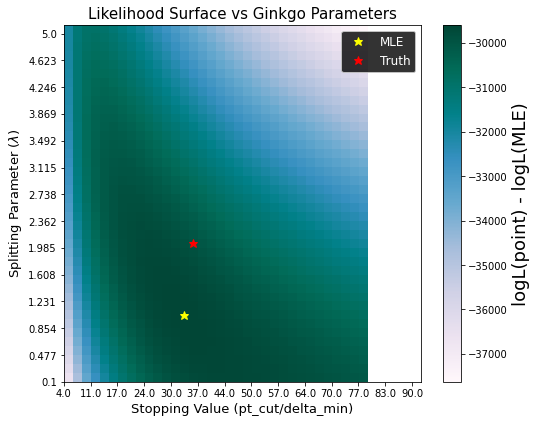

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(8,8)

cm = ax.imshow(likelihood_surface, cmap="PuBuGn", interpolation="none", extent=[0,40,0,40], origin="lower")
ax.plot(mle_coords[1]+0.5, mle_coords[0]+0.5, '*', color='yellow', markersize=9, label="MLE")
ax.plot(truth_bin[0]+0.5, truth_bin[1]+0.5, "*", color="red", markersize=9, label="Truth")
cb = fig.colorbar(cm, ax=ax, shrink=0.82)
cb.set_label(label="logL(point) - logL(MLE)", size=18)
ax.legend(labelcolor="white", facecolor="black", fontsize="large")

ax.set_title("Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Stopping Value (pt_cut/delta_min)", size=13)
ax.set_ylabel("Splitting Parameter ($\lambda$)", size=13)
ax.set_xticks(np.arange(0, 40, 3))
ax.set_yticks(np.arange(0, 40, 3))
ax.set_xticklabels(np.round(cut_vals[::3], decimals=0))
ax.set_yticklabels(np.round(lambda_vals[::3], decimals=3));

In [26]:
likelihood_surface[truth_bin[1], truth_bin[0]] - likelihood_surface[mle_coords]

-384.5555338568556

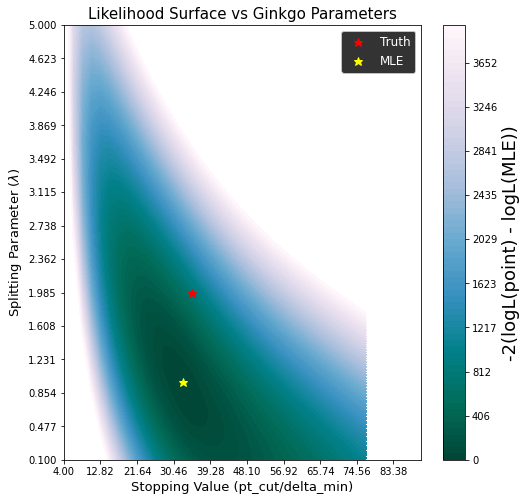

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(8,8)

Z = -2*(likelihood_surface-likelihood_surface[mle_coords])

# Boost the upper limit to avoid truncation errors.
levels = -2*np.flip(np.linspace(-2, 0, 70))*1000

cset1 = ax.contourf(grid_cut, grid_lambda, Z,
                    levels, cmap="PuBuGn_r")
cb = fig.colorbar(cset1, ax=ax)
cb.set_label(label="-2(logL(point) - logL(MLE))", size=18)

ax.plot(cut_vals[truth_bin[0]], lambda_vals[truth_bin[1]], "*", color="red", markersize=9, label="Truth")
ax.plot(cut_vals[mle_coords[1]], lambda_vals[mle_coords[0]], "*", color="yellow", markersize=9, label="MLE")

ax.legend(labelcolor="white", facecolor="black", fontsize="large")

ax.set_title("Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Stopping Value (pt_cut/delta_min)", size=13)
ax.set_ylabel("Splitting Parameter ($\lambda$)", size=13)
#ax.set_yscale("log")
ax.set_xticks(cut_vals[::4])
ax.set_yticks(lambda_vals[::3]);